In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa as tsa
import statsmodels as sm
from datetime import datetime
import os
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

#Tensorflow
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential,save_model,load_model
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from keras.metrics import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
import keras

#Pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [9]:
pip install openpyxl

  Using cached openpyxl-3.1.5-py2.py3-none-any.whl.metadata (2.5 kB)
  Using cached et_xmlfile-2.0.0-py3-none-any.whl.metadata (2.7 kB)
Using cached openpyxl-3.1.5-py2.py3-none-any.whl (250 kB)
Using cached et_xmlfile-2.0.0-py3-none-any.whl (18 kB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [10]:
import pandas as pd

# Lee el archivo Excel
df = pd.read_excel('IMPORTACIONES.xlsx')

# Guarda como CSV
df.to_csv('IMPORTACIONES.csv', index=False)

In [14]:
tf.random.set_seed(123)
# Make sure the file name is correct and includes the extension, e.g., 'IMPORTACIONES.csv'
imp = pd.read_csv("IMPORTACIONES.csv", parse_dates=['Fecha'], index_col='Fecha')
print('\n Parsed Data:')
print(imp.head())

# ...existing code...
# Agrupa por año y suma los valores de cada columna
imp_anual = imp.resample('Y').sum()

# Si solo quieres ver la columna Diesel por año:
diesel_anual = imp['Diesel'].resample('Y').sum()

print(diesel_anual)
# ...existing code...



 Parsed Data:
            Aceites lubricantes  Asfalto      Bunker  Ceras  \
Fecha                                                         
2001-01-01                  0.0  27748.99  214581.84    0.0   
2001-02-01                  0.0   7503.57  294609.00    0.0   
2001-03-01                  0.0  26304.32  315263.80    0.0   
2001-04-01                  0.0   7885.89  205653.00    0.0   
2001-05-01                  0.0   8443.16  278371.30    0.0   

            Combustible turbo jet     Diesel  Diesel ultra bajo azufre  \
Fecha                                                                    
2001-01-01                    0.0  566101.99                       0.0   
2001-02-01                    0.0  489525.80                       0.0   
2001-03-01                    0.0  575559.68                       0.0   
2001-04-01                    0.0  437745.42                       0.0   
2001-05-01                    0.0  552609.13                       0.0   

            Gas licuado 

C:\Users\Javier Chiquin\AppData\Local\Temp\ipykernel_28020\694552765.py:9: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  imp_anual = imp.resample('Y').sum()
C:\Users\Javier Chiquin\AppData\Local\Temp\ipykernel_28020\694552765.py:12: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  diesel_anual = imp['Diesel'].resample('Y').sum()


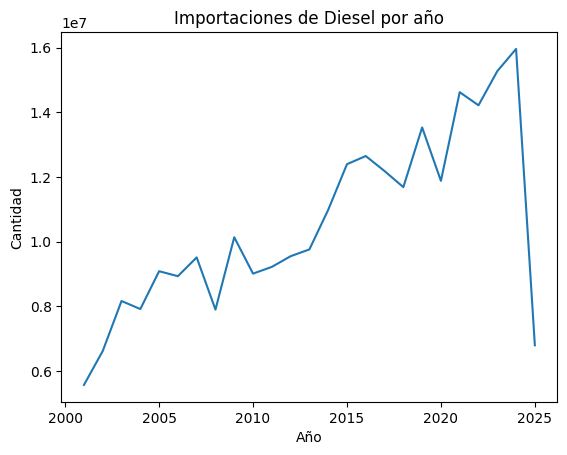

In [ ]:
plt.plot(diesel_anual.index.year, diesel_anual.values)
plt.gca().set(title="Importaciones de Diesel por año", xlabel="Año", ylabel="Cantidad")
plt.show()

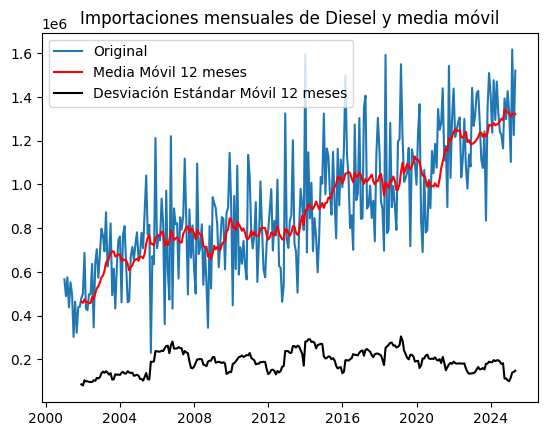

In [26]:
# Descomposición estacional
mediaMovil = imp['Diesel'].rolling(window=12).mean()
deMovil = imp['Diesel'].rolling(window=12).std()
plt.plot(imp['Diesel'], label='Original')
plt.plot(mediaMovil, label='Media Móvil 12 meses', color='red')
plt.plot(deMovil, label='Desviación Estándar Móvil 12 meses', color='black')
plt.legend()
plt.title('Importaciones mensuales de Diesel y media móvil')
plt.show()


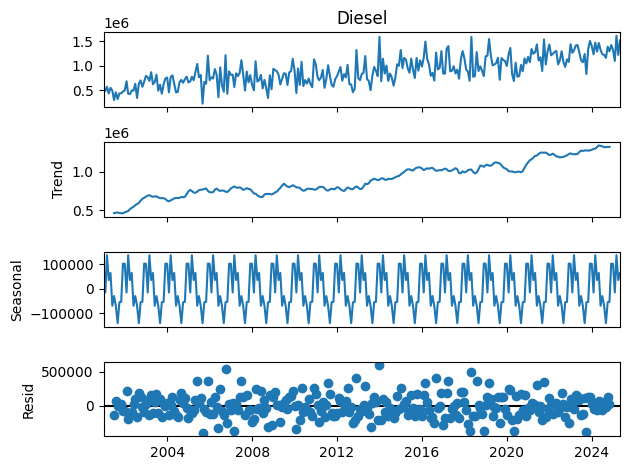

In [28]:
# Descomposición estacional sobre la serie mensual de Diesel
descomposicion = seasonal_decompose(imp['Diesel'], model='additive', period=12)
descomposicion.plot()
plt.show()


Tendencia (Trend): Se observa una tendencia creciente a lo largo de los años, con algunos periodos de estabilidad y repuntes, lo que indica un aumento sostenido en las importaciones de Diesel.

Estacionalidad (Seasonal): Ahora sí se detecta un patrón estacional claro, con oscilaciones regulares cada año. Esto significa que hay meses en los que las importaciones tienden a subir o bajar de forma recurrente, probablemente por factores económicos, climáticos o de demanda.

Residuales (Resid): Los residuales muestran variabilidad alrededor de cero, lo que indica que el modelo de descomposición logra capturar bien la tendencia y la estacionalidad, aunque aún hay cierta variabilidad no explicada (ruido).

In [29]:
print('Resultados del Test de Dickey Fuller')
dfTest_D = adfuller(imp['Diesel'], autolag='AIC')
salidaDf = pd.Series(dfTest_D[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest_D[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller
Estadístico de prueba         -0.788665
p-value                        0.822429
# de retardos usados          13.000000
# de observaciones usadas    279.000000
Critical Value (1%)           -3.454008
Critical Value (5%)           -2.871956
Critical Value (10%)          -2.572320
dtype: float64


El p-value es mayor a 0.05 por lo que no se puede rechazar la hipótesis nula de que existen raices unitarias. La serie no es estacionaria en media. Vamos a probar con una diferenciación

In [30]:
print('Resultados del Test de Dickey Fuller para una diferenciación de la serie')
ts_imp_D_diff = imp['Diesel'].diff()
ts_imp_D_diff.fillna(0,inplace=True)
dfTest = adfuller(ts_imp_D_diff)
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller para una diferenciación de la serie
Estadístico de prueba       -9.223948e+00
p-value                      1.749540e-15
# de retardos usados         1.200000e+01
# de observaciones usadas    2.800000e+02
Critical Value (1%)         -3.453922e+00
Critical Value (5%)         -2.871918e+00
Critical Value (10%)        -2.572300e+00
dtype: float64


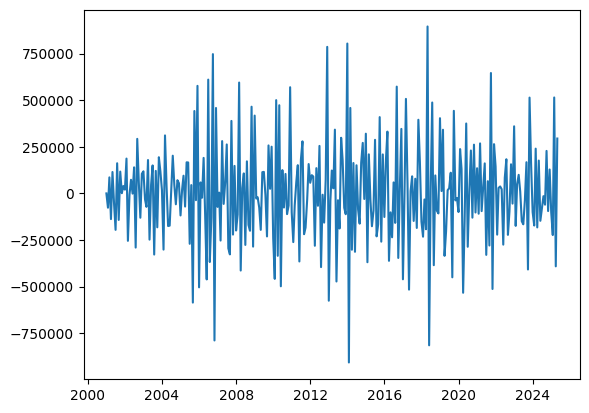

In [31]:
plt.plot(ts_imp_D_diff)

In [33]:
scaler = StandardScaler()
ts_imp_D_scaled = scaler.fit_transform(ts_imp_D_diff.values.reshape(-1, 1))
ts_imp_D_scaled[1:7]


array([[-0.29281567],
       [ 0.30360661],
       [-0.51742506],
       [ 0.40934885],
       [-0.21277562],
       [-0.72902441]])

In [34]:
val_prueba = round(0.2*len(ts_imp_D_scaled))
val_prueba

59

In [35]:
entrenamiento = round(0.6*len(ts_imp_D_scaled))
val_prueba = round(0.2*len(ts_imp_D_scaled))
test = ts_imp_D_scaled[(entrenamiento+val_prueba)-1:]
validation = ts_imp_D_scaled[(entrenamiento):entrenamiento+val_prueba+1]
train = ts_imp_D_scaled[0:entrenamiento]
train=np.insert(train,0,0)
train=np.reshape(train,(train.shape[0],1))
len(test)

59

In [36]:
from operator import concat


def supervisada(serie,retrasos = 1):
    serie_x = []
    serie_y = []
    for i in range(len(serie)-retrasos):
        valor = serie[i:(i+retrasos),0]
        valor_sig = serie[i+retrasos,0]
        serie_x.append(valor)
        serie_y.append(valor_sig)
    return np.array(serie_x), np.array(serie_y)

x_train,y_train = supervisada(train)
x_val,y_val = supervisada(validation)
x_test,y_test = supervisada(test)



In [37]:
print(train[0:6])
print(x_train[0:6])
print(y_train[0:6])


[[ 0.        ]
 [-0.01194902]
 [-0.29281567]
 [ 0.30360661]
 [-0.51742506]
 [ 0.40934885]]
[[ 0.        ]
 [-0.01194902]
 [-0.29281567]
 [ 0.30360661]
 [-0.51742506]
 [ 0.40934885]]
[-0.01194902 -0.29281567  0.30360661 -0.51742506  0.40934885 -0.21277562]


Creando el modelo

In [38]:
x_train = np.reshape(x_train,(x_train.shape[0],1,1))
x_val = np.reshape(x_val, (x_val.shape[0],1,1))
x_test = np.reshape(x_test, (x_test.shape[0],1,1))
len(x_val)

59

In [39]:
x_train

array([[[ 0.        ]],

       [[-0.01194902]],

       [[-0.29281567]],

       [[ 0.30360661]],

       [[-0.51742506]],

       [[ 0.40934885]],

       [[-0.21277562]],

       [[-0.72902441]],

       [[ 0.5815355 ]],

       [[-0.53353381]],

       [[ 0.41731863]],

       [[-0.00734298]],

       [[ 0.13380199]],

       [[ 0.06162003]],

       [[ 0.67349988]],

       [[-0.94498534]],

       [[-0.04081869]],

       [[ 0.25622009]],

       [[-0.01545192]],

       [[ 0.50118159]],

       [[-1.07745723]],

       [[ 1.06164811]],

       [[ 0.2257857 ]],

       [[-0.49045219]],

       [[ 0.37485838]],

       [[ 0.42303355]],

       [[-0.12723448]],

       [[-0.27592234]],

       [[ 0.64517809]],

       [[-0.921246  ]],

       [[ 0.15931096]],

       [[ 0.53870509]],

       [[-1.21472335]],

       [[ 0.43121939]],

       [[-0.67886147]],

       [[ 0.6999898 ]],

       [[ 0.42208124]],

       [[ 0.04989229]],

       [[-1.1175651 ]],

       [[ 1.12940181]],



### Creamos el modelo.   
#### Tensor Flow
Vamos a utilizar solo una capa LSTM 

In [40]:
lote = 1
unidades =  1
paso = 1
caracteristicas = 1 #es univariada

inputs = keras.layers.Input((paso,caracteristicas))
lstm_out = keras.layers.LSTM(lote)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

modelo1 = keras.Model(inputs=inputs, outputs=outputs)
modelo1.summary()

#Tensor Flow 2
#modelo1 = Sequential()
#modelo1.add(LSTM(lote,batch_input_shape=(lote,paso,caracteristicas),stateful=True))
#modelo1.add(Dense(1))
#modelo1.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1, 1)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 1)              │            12 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14 (56.00 B)

 Trainable params: 14 (56.00 B)

 Non-trainable params: 0 (0.00 B)

In [41]:
#early_stop = EarlyStopping(monitor='val_loss', patience=1)
modelo1.compile(loss='mean_squared_error',optimizer=Adam(learning_rate=0.1), metrics = [RootMeanSquaredError()])

In [42]:
modelo1

<Functional name=functional, built=True>

In [43]:
epocas = 150
history= modelo1.fit(
    x = x_train,
    y = y_train,
    batch_size = lote,
    epochs = epocas,
    shuffle = False,
    validation_data = (x_val,y_val),
    #callbacks=[early_stop],
    verbose=1
)

Epoch 1/150
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5730 - root_mean_squared_error: 0.7302 - val_loss: 1.0565 - val_root_mean_squared_error: 1.0279
Epoch 2/150
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5961 - root_mean_squared_error: 0.7582 - val_loss: 1.0572 - val_root_mean_squared_error: 1.0282
Epoch 3/150
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5812 - root_mean_squared_error: 0.7477 - val_loss: 1.0683 - val_root_mean_squared_error: 1.0336
Epoch 4/150
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5761 - root_mean_squared_error: 0.7441 - val_loss: 1.0759 - val_root_mean_squared_error: 1.0372
Epoch 5/150
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5766 - root_mean_squared_error: 0.7444 - val_loss: 1.0809 - val_root_mean_squared_error: 1.0397
Epoch 6/150
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5786 - root_mean_squared_error: 0.7457 - val_loss: 1.0863 - val_root_mean_squared_error: 1.0423
Epoch 7/150
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 2m

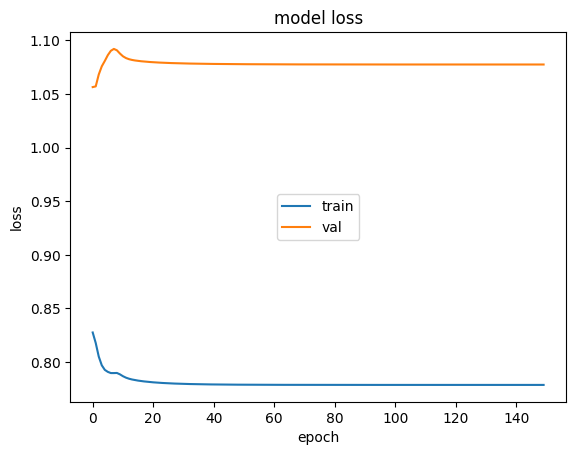

In [44]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='center')

<Axes: >

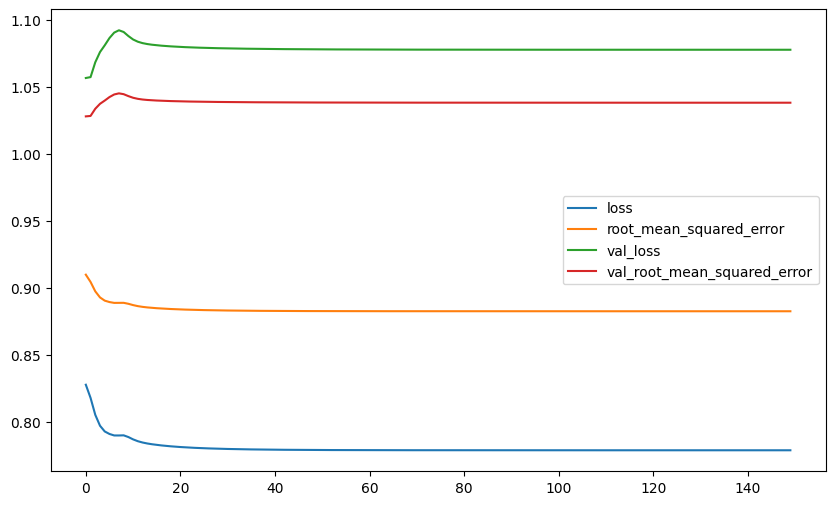

In [45]:
losses_df1 = pd.DataFrame(history.history)

losses_df1.plot(figsize = (10,6))

Evaluemos ahora el modelo según la pérdida en cada uno de los conjuntos de datos.

In [47]:
print("Pérdida en Entrenamiento")
modelo1.evaluate(
    x = x_train,
    y = y_train
)
print("Pérdida en Validación")
modelo1.evaluate(
    x = x_val,
    y = y_val
)
print("Pérdida en Prueba")
modelo1.evaluate(
    x = x_test,
    y = y_test
)

Pérdida en Entrenamiento
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6525 - root_mean_squared_error: 0.8012  
Pérdida en Validación
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 1.1198 - root_mean_squared_error: 1.0578
Pérdida en Prueba
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.5360 - root_mean_squared_error: 0.7313


[0.5719047784805298, 0.756243884563446]

In [49]:
prediccion_val = []

def prediccion_fun(data,modelo, batch_size,scaler,dif=False,dif_cant=1, Series = None , n=1):
    prediccion = [0]* (len(data))
    i=0
    for X in data:
        X = np.reshape(X,(1,1,1))
        yhat = modelo1.predict(X, batch_size=batch_size,verbose=0)
        # invert scaling
        yhat = scaler.inverse_transform(yhat)
        if dif:
             # invert differencing
            yhat  = yhat + Series[(n+dif_cant*i)]
        # store
        prediccion[i]=yhat[0][0]
        i = i+1
    return prediccion
prediccion_val = prediccion_fun(x_val,modelo1, 1,scaler,dif=True,dif_cant=1, Series = imp['Diesel'].values , n=entrenamiento)
prediccion_test = prediccion_fun(x_test,modelo1, 1,scaler,dif=True,dif_cant=1, Series = imp['Diesel'].values , n=entrenamiento+val_prueba)


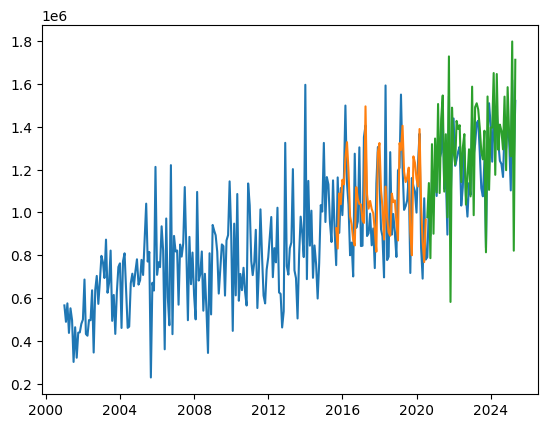

In [52]:
df_val = pd.DataFrame(prediccion_val,index=imp['Diesel'][(entrenamiento):entrenamiento+val_prueba].index)
df_test = pd.DataFrame(prediccion_test,index=imp['Diesel'][entrenamiento+len(df_val):len(imp['Diesel'])].index)


plt.plot(imp['Diesel'])
plt.plot(df_val)
plt.plot(df_test)

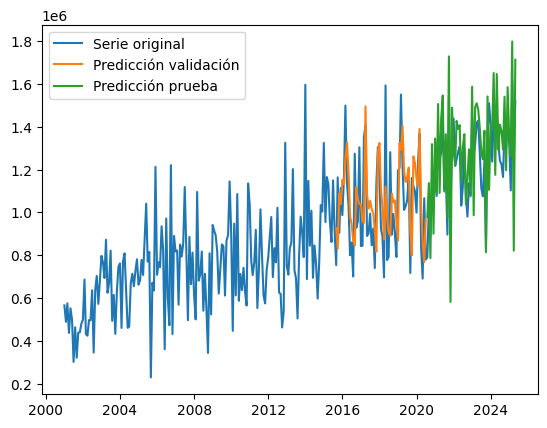

In [54]:
plt.plot(imp['Diesel'], label='Serie original')
plt.plot(df_val, label='Predicción validación')
plt.plot(df_test, label='Predicción prueba')
plt.legend()
plt.show()

## Pytorch

Se define la clase que hereda de los modelos nn de pytorch para este modelo en específico

In [55]:
class LSTMMiModelo(nn.Module):
    def __init__(self,input_size=1,hidden_size=20, num_layers = 1,output_size = 1 ):
        super().__init__()
        self.lstm = nn.LSTM(input_size,hidden_size,num_layers,batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)  
        self.hidden_size = hidden_size

    def forward(self,x):
        # x shape: (batch, seq_len, input_size)
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        c0 = torch.zeros(1, x.size(0), self.hidden_size)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [56]:
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        xs.append(data[i:(i + seq_length)])
        ys.append(data[i + seq_length])
    return np.array(xs), np.array(ys)
SEQ_LENGTH = 12 #Por el ciclo estacional, una ventana de un año

# Después, rehace tus ventanas:
x_train, y_train = create_sequences(train, SEQ_LENGTH)
x_val, y_val     = create_sequences(validation, SEQ_LENGTH)
x_test, y_test   = create_sequences(test, SEQ_LENGTH)

In [57]:
model = LSTMMiModelo()
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

#Preparación de los datos
x_train_tensor = torch.from_numpy(x_train).float()        
y_train_tensor = torch.from_numpy(y_train).float()
x_val_tensor = torch.from_numpy(x_val).float()
y_val_tensor = torch.from_numpy(y_val).float()
x_test_tensor = torch.from_numpy(x_test).float()
y_test_tensor = torch.from_numpy(y_test).float()

train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

### Entrenamiento
En pytorch hay que hacer el entrenamiento "a mano" para tener el control del todo

In [58]:

train_losses = []
val_losses = []
model.train()
running_train_loss = 0.0
for epoch in range(epocas):
    running_train_loss = 0.0  # Acumula la pérdida de la época
    for xb, yb in train_loader:  # Recorre cada batch
        outputs = model(xb)
        loss = loss_fn(outputs, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item() * xb.size(0)
    
    # Calcula y muestra la pérdida promedio en el entrenamiento de la época
    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss) 

    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            outputs = model(xb)
            loss = loss_fn(outputs, yb)
            running_val_loss += loss.item() * xb.size(0)
    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)
    if (epoch+1) % 10 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}, Loss promedio: {epoch_train_loss:.5f}")

Epoch 1, Loss promedio: 1.03851
Epoch 10, Loss promedio: 0.58739
Epoch 20, Loss promedio: 0.56115
Epoch 30, Loss promedio: 0.58894
Epoch 40, Loss promedio: 0.57249
Epoch 50, Loss promedio: 0.52509
Epoch 60, Loss promedio: 0.46037
Epoch 70, Loss promedio: 0.42374
Epoch 80, Loss promedio: 0.37357
Epoch 90, Loss promedio: 0.35717
Epoch 100, Loss promedio: 0.25115
Epoch 110, Loss promedio: 0.15885
Epoch 120, Loss promedio: 0.12129
Epoch 130, Loss promedio: 0.06629
Epoch 140, Loss promedio: 0.02193
Epoch 150, Loss promedio: 0.01676


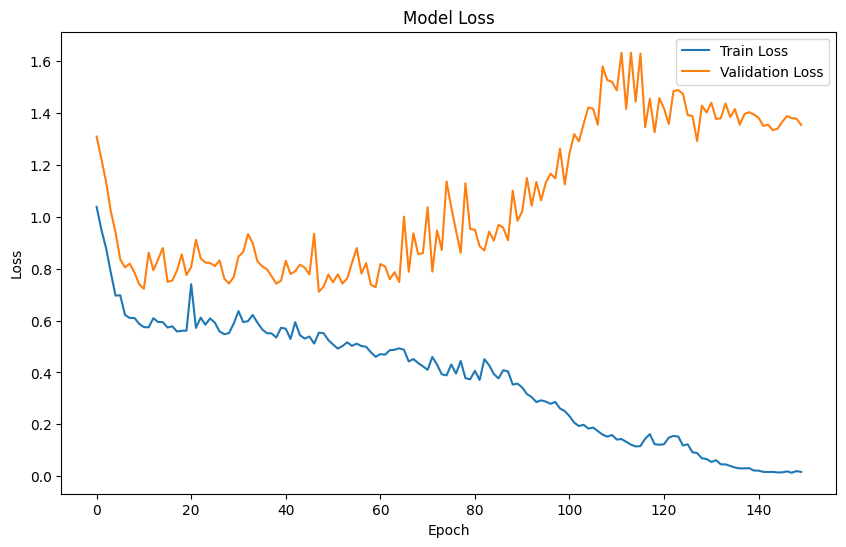

In [59]:
plt.figure(figsize=(10,6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [60]:
x_test_tensor = torch.from_numpy(x_test).float()
y_test_tensor = torch.from_numpy(y_test).float()
model.eval()
with torch.no_grad():
    # Forma: (num_ejemplos, ventana, 1)
    y_pred_test = model(x_test_tensor)
    y_pred_test = y_pred_test.numpy()  # Convierte a numpy para graficar

In [61]:
#Desnormalizar
y_pred_test_inv = scaler.inverse_transform(y_pred_test)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

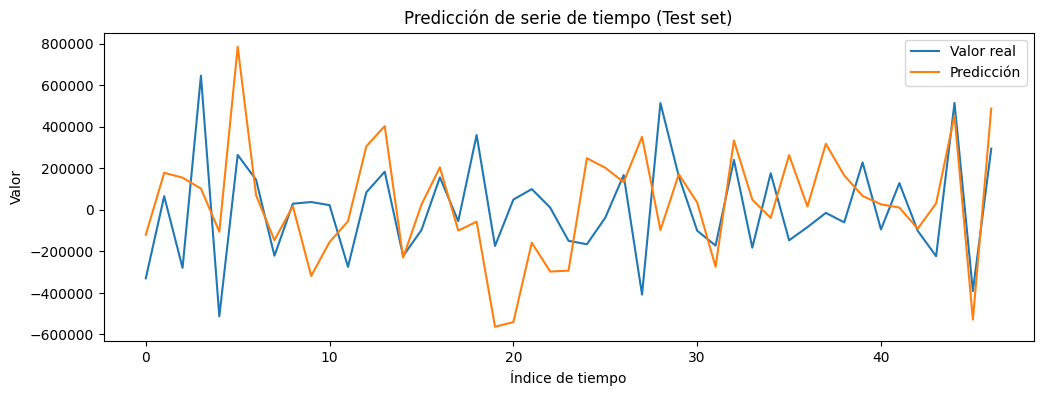

In [62]:
# Graficar
plt.figure(figsize=(12, 4))
plt.plot(y_test_inv, label='Valor real')
plt.plot(y_pred_test_inv, label='Predicción')
plt.title('Predicción de serie de tiempo (Test set)')
plt.xlabel('Índice de tiempo')
plt.ylabel('Valor')
plt.legend()
plt.show()